In [10]:
import sys

In [11]:
sys.path.append("/home/jwaschur/rankability_toolbox")

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
!pip install tqdm

In [14]:
import itertools
import numpy as np
import pandas as pd
import pyrankability
import random
import math
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm


In [15]:
r1 = [5, 4, 3, 2, 1]
r2 = [5, 4, 3, 2, 1]
tau, pval = stats.kendalltau(r1,r2)
print(tau, pval)

r1 = [5, 4, 3, 2, 1]
r2 = [1, 2, 3, 4, 5]
tau, pval = stats.kendalltau(r1,r2)
print(tau, pval)

0.9999999999999999 0.016666666666666666
-0.9999999999999999 0.016666666666666666


In [6]:
D=np.array([[0,1,1,1,1,1,1,1],
            [0,0,1,1,1,1,1,1],
            [0,0,0,1,1,1,1,1],
            [0,0,0,0,1,1,1,1],
            [0,0,0,0,0,1,1,1],
            [0,0,0,0,0,0,1,1],
            [0,0,0,0,0,0,0,1],
            [0,0,0,0,0,0,0,0]])
k, details = pyrankability.lop.lp(D)
P, info = pyrankability.lop.find_P_from_x(D, k, details)
print(P[0])

Academic license - for non-commercial use only
[7, 6, 5, 4, 3, 2, 1, 0]


In [7]:
def generate_noisy_D(n, noise_percent):
    D = np.ndarray((n,n), int)
    for i in range(n):
        D[i,i] = 0
        for j in range(i+1, n):
            if  random.random() <= noise_percent:
                D[i,j] = 0
                D[j,i] = 1
            else:
                D[i,j] = 1
                D[j,i] = 0
    return D

def get_perfect_ranking(n):
    ranking = []
    for i in range(n):
        ranking.append(i)
    ranking.reverse()
    return ranking

In [8]:
n = 8
noise_percent = 0.35
n_graphs = 2000
perfect_ranking = get_perfect_ranking(n)
rs = []
taus = []
m_rs = []
m_taus = []

# I have added a ",debug=False" parameter to the find_P_from_x method in my lop file
# to toggle off the "Going to loop for ___" output. If you run this without those changes,
# the tqdm progress bar will not function correctly and you'll see every update to the
# bar printed on a new line. The content of the prototype will still work correctly, but output
# will be super verbose.
for it in tqdm(range(n_graphs), ascii=True):
    D_tilde = generate_noisy_D(n, noise_percent)
    k, details = pyrankability.lop.lp(D_tilde)
    P, info = pyrankability.lop.find_P_from_x(D_tilde, k, details)
    r = 1.0 - (k*len(P) / ((n*n - n)/2*math.factorial(n)))
    mean_tau = 0.0
    for rank in P:
        tau, pval = stats.kendalltau(perfect_ranking,rank)
        rs.append(r)
        taus.append(tau)
        mean_tau += tau
        mean_tau /= len(P)
    m_taus.append(mean_tau)
    m_rs.append(r)

100%|##########| 2000/2000 [2:34:49<00:00,  4.64s/it]    


Correlation: 0.111144


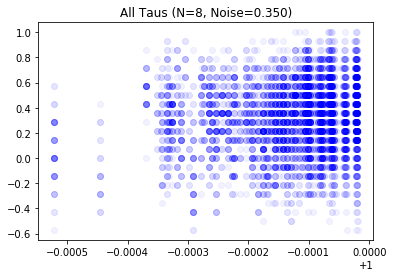

Correlation: 0.458555


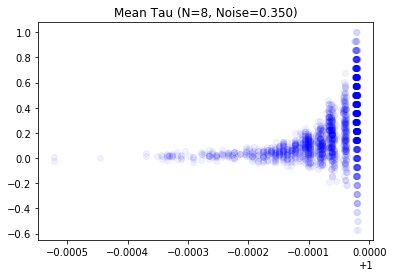

Correlation: 0.082128


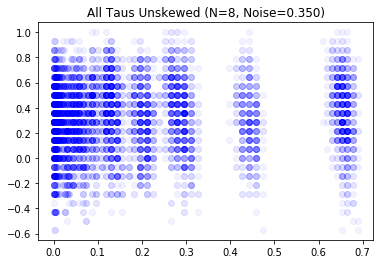

Correlation: 0.549856


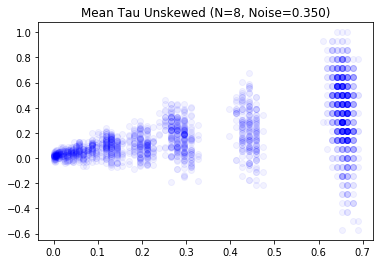

In [9]:
r_tau_corr, pval = stats.pearsonr(rs, taus)
print("Correlation: %f" % r_tau_corr)
plt.title("All Taus (N=%d, Noise=%.3f)"%(n, noise_percent))
plt.plot(rs, taus, "bo", alpha=0.05)
plt.show()

r_mtau_corr, pval = stats.pearsonr(m_rs, m_taus)
print("Correlation: %f" % r_mtau_corr)
plt.title("Mean Tau (N=%d, Noise=%.3f)"%(n, noise_percent))
plt.plot(m_rs, m_taus, "bo", alpha=0.05)
plt.show()

unskewed_rs = np.array(rs)**20000
unskewed_m_rs = np.array(m_rs)**20000

r_tau_unskew_corr, pval = stats.pearsonr(unskewed_rs, taus)
print("Correlation: %f" % r_tau_unskew_corr)
plt.title("All Taus Unskewed (N=%d, Noise=%.3f)"%(n, noise_percent))
plt.plot(unskewed_rs, taus, "bo", alpha=0.05)
plt.show()

r_mtau_unskew_corr, pval = stats.pearsonr(unskewed_m_rs, m_taus)
print("Correlation: %f" % r_mtau_unskew_corr)
plt.title("Mean Tau Unskewed (N=%d, Noise=%.3f)"%(n, noise_percent))
plt.plot(unskewed_m_rs, m_taus, "bo", alpha=0.05)
plt.show()